In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv
import time
import scipy

# Upscaling for Marginal Observations: Gene Expression

We have investigated marginal observations: observing the number of molecules m but not the state (on / off) of a gene G that controls the production of these molecules, and upscaling for capture efficiency: measurements of molecule numbers are only a proportion ('capture efficiency') of the true values.

Now we consider both levels of 'obfuscation' at the same time: we observe a proportion of the marginal number of molecules but not the state of a gene. We wil use the B upscaling method to map bounds on the 'observed' marginal into bounds on the 'true' marginal, then use gene expression A method (sums of joints = marginal) to map to bounds on the (true) joint distribution which can then be included in the optimization for parameters.

However, it is unclear whether any results can be produced, since each of marginal observations and upscaling alone are difficult problems which are not easy to obtain results for.

### Simulation

To test we will need to simulate data, first sampling from the 'true' stationary distribution of gene expression using gillespie / SSA, then using a binomial downsampling to simulate an 'observed' stationary distribution:

- sample path approximate: gillespie to simulate sample path, taking stationary samples
- simulated samples: runs 'sample path approximate' to get 'true' stationary samples, then downsamples to get 'observed' samples
- bootstrap: given stationary samples, produce bootstrap confidence intervals on the stationary distribution

NOTE: all samples / distributions are of the m marginal, gene g is not observed

In [2]:
def sample_path_approximate(initial_state, params, n, tmax, ts, plot=False):
    """
    Simulate a single sample path of gene expression
    Sample values at intervals ts after a burn-in time of tmax to give n values

    initial state
    params = [k_on, k_off, k_tx, k_deg]
    n = total number of samples
    tmax = burn-in simulation time
    ts = time between successive samples

    return samples of m
    """

    # parameters
    k_on = params[0]
    k_off = params[1]
    k_tx = params[2]
    k_deg = params[3]

    # initialise time and state (also store jump times)
    t = 0
    path = [(initial_state[0], initial_state[1])]
    jump_times = [0]

    # simulate for: burn-in time + (n-1) times between n samples
    while t < tmax + (n - 1) * ts:

        # simulate holding time of current state (m,g)
        m, g = path[-1][0], path[-1][1]

        # define rates
        # q(x,x+(0,1)): gene turns on if off
        q_on = (1 - g) * k_on
        # q(x,x+(0,-1)): gene turns off if on
        q_off = g * k_off
        # q(x,x+(1,0)): transcription if gene on
        q_tx = g * k_tx
        # q(x,x+(-1,0)): degradation if  there are molecules
        q_deg = m * k_deg
        # -q(x,x): holding rate = sum q(x,y) over y
        q_hold = q_on + q_off + q_tx + q_deg

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        # P(x -> y) = q_xy / q_hold
        outcome = [1,2,3,4]
        prob = [q_on / q_hold, q_off / q_hold, q_tx / q_hold, q_deg / q_hold]
        jump = np.random.choice(outcome,p=prob)
        # jump to new state
        if jump == 1:
            path.append((m,g + 1))
        elif jump == 2:
            path.append((m,g - 1))
        elif jump == 3:
            path.append((m + 1,g))
        elif jump == 4:
            path.append((m - 1,g))

    # take the m marginal states
    m_path = [state[0] for state in path]

    # create step function of sample path from jump times and jump values
    path_function = scipy.interpolate.interp1d(jump_times, m_path, kind='previous')
    
    # take values at sampling times as samples
    sample_times = [tmax + i * ts for i in range(n)]
    samples = path_function(sample_times)
    samples = [int(x) for x in samples]

    # plot sample path with burn-in and sampled values
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, path_function(x), label="Sample path")
        plt.axvline(tmax, label="Burn-in time: t_max", color="orange")
        plt.scatter(sample_times, path_function(sample_times), color="red", label="Samples")
        plt.legend()
        plt.show()

    return samples

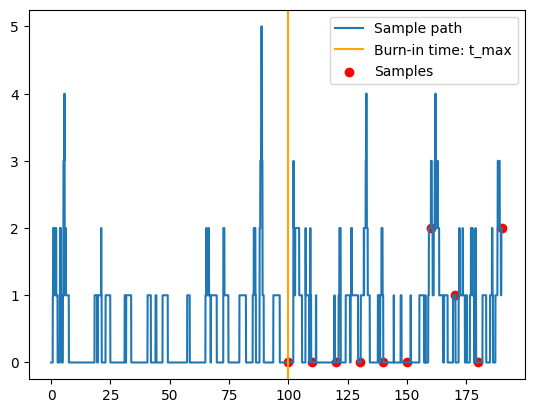

In [6]:
sample = sample_path_approximate((0, 0), [1, 1, 1, 1], 10, 100, 10, plot=True)

In [9]:
def simulated_samples(params, n, beta, tmax=100, ts=10, plot_path=False, plot_true=False, plot_downsampled=False):
    '''
    Simulate 'true' and 'downsampled' marginal samples of size n from gene expression.

    Input:
    params = [k_on, k_off, k_tx, k_deg]
    beta: capture efficicency for downsampling, float or list (of length n)
    tmax: burn in time for sample paths
    ts: time between samples
    plot_path: plot sample path
    plot_true: histogram of true sample
    plot_downsampled: histogram of downsampled sample

    Output:
    sample_true: true sample of size n
    sample_downsampled: downsampled sample of size n
    '''
    # simulate 'true' sample of size n
    sample_true = sample_path_approximate((0, 0), params, n, tmax, ts, plot=plot_path)

    # for each count, draw from Binomial(count, beta)
    sample_downsampled = np.random.binomial(sample_true, beta)

    # plot histograms
    if plot_true:
        plt.hist(sample_true, bins=np.max(sample_true))
        plt.title("Histogram of samples from true stationary distribution")
        plt.xlabel("True counts")
        plt.show()
    if plot_downsampled:
        plt.hist(sample_downsampled, bins=np.max(sample_downsampled))
        plt.title("Histogram of samples from downsampled stationary distribution")
        plt.xlabel(f"Observed counts, beta = {beta}")
        plt.show()

    return {'sample_true': sample_true, 'sample_downsampled': sample_downsampled}

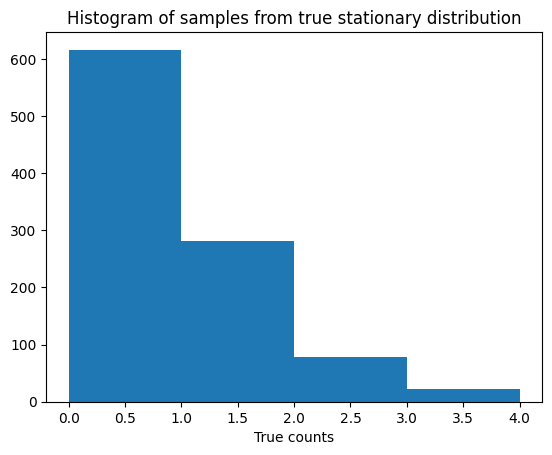

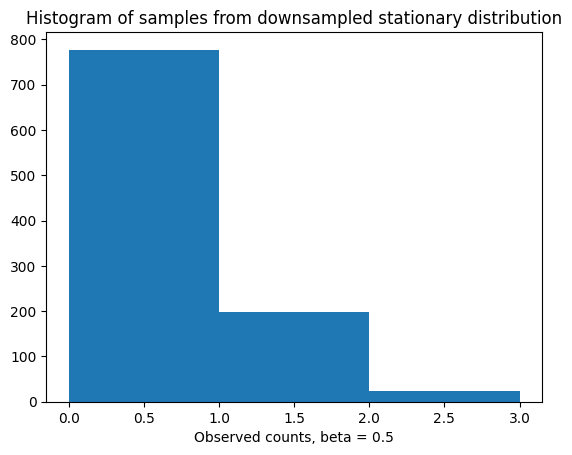

In [12]:
samples = simulated_samples([1, 1, 1, 1], 1000, 0.5, plot_true=True, plot_downsampled=True)

In [17]:
def bootstrap_approx(sample, N, tmax=100, ts=10, plot=False, printing=False):
    """
    Simulate sample paths of reaction system, bootstrap to produce confidence
    intervals on the m marginals of the stationary distributin.

    Arguments:
    N: number of bootstrap samples
    tmax: burn-in time of sample path
    ts: time between each sample
    plot: plot the computed bounds
    print: print the computed bounds

    Returns:
    intervals: list of confidence intervals for m marginals p(0), ..., p(x_max)
        of the stationary distribution of the chain (for largest state observed x_max)
    """

    # n stationary samples (of m marginal)
    n = len(sample)

    # maximum state observed (+ 1)
    M = int(np.nanmax(sample)) + 1

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(sample, size=(N, n))
    # produce N x M array of counts of states:
    # offset each row by multiple of M for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*M
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N * M).reshape(-1, M)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(M)]

    # plot histograms and CI
    for x in range(M):
        if printing:
            print(f"95% CI for m marginal p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
        if plot:
            plt.hist(counts[:, x] / n)
            plt.title(f"Hist of m marginal p({x})")
            plt.axvline(intervals[x][0], color="red")
            plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

In [20]:
intervals = bootstrap_approx(samples['sample_downsampled'], 1000, printing=True)

95% CI for m marginal p(0) is: (0.751, 0.803)
95% CI for m marginal p(1) is: (0.174, 0.223)
95% CI for m marginal p(2) is: (0.012, 0.029)
95% CI for m marginal p(3) is: (0.001, 0.008)


### Solving

We assume that we have access to downscaled samples from the m-marginal stationary distribtion, and an estimate (or true value) of the capture efficiency. Given this we can bootstrap to produce confidence intervals on the downsampled marginal stationary distribution $\hat{p}_{obs} = P(M_obs = m_obs) $, computing a binomial upscaling matrix B we can form conditions on the 'true' marginal stationary distribution $ \hat{p} = P(M = m) $ with $ \hat{p}_{obs} = B \hat{p} $ (truncating in practice).

Finally we can form conditions on the full / joint 'true' stationary distribution $ p = P(M = m, G = g) $ with $ \hat{p} = Ap $ (pairs of joints with g = 0, 1 equal the marginal). This allows bounds on the joint distribution $p$ (or rather on $BAp$) which also satisfies the CME $Qp = 0$, allowing us to form a linear program (via z substitutions) to solve for bounds on the parameters of interest e.g. $k_{tx}$

- B matrix: given capture effiency (or list), x_max (largest observed state considered), x_max_0 (largest upscaled state considered), compute B upscaling matrix
- mean_CI: given a sample, computes 95% CI on its mean. This is used in the truncation error term of the LP constraints.
- gene expression LP upscaling: use the data to solve LP to bound parameters

In [22]:
def B_matrix(beta, x_max, x_max_0):
    """
    Construct the binomial upscaling matrix B

    Arguments:
    beta: capture efficiencies for each cell
    x_max: observed truncation T = {0, ... , x_max}
    x_max_0: 'true' truncation T_0 = {0, ..., x_max_0}

    Returns:
    B: |T| x |T_0| upscaling matrix (x_max + 1, x_max_0 + 1)
    """
    if type(beta) != list:
        beta_list = [beta]
    else:
        beta_list = beta

    # initialise B
    B = np.zeros((x_max + 1, x_max_0 + 1))
    # loop over beta_j values
    for beta_j in beta_list:
        # create B_j matrix
        f = lambda x, x0: scipy.special.comb(x0, x) * beta_j**x * (1 - beta_j)**(x0 - x)
        B_j = np.fromfunction(f, (x_max + 1, x_max_0 + 1))
        # add to B
        B += B_j
    # scale B
    B = B / len(beta_list)
    return B

In [23]:
def mean_CI(sample):
    '''Compute 95% confidence interval for the mean of the sample.'''
    # sample mean
    mean = np.mean(sample)
    # sample standard deviation
    std = np.std(sample)
    # size of the sample
    n = len(sample)
    # compute CI
    return (mean - 1.96 * (std / np.sqrt(n)), mean + 1.96 * (std / np.sqrt(n)))

In [116]:
def gene_expression_LP_upscaling(params, intervals, beta, x_max, x_max_0, sample_mean, frechet_bounds=False, frechet_bounds_further=False, print_solution=True):
    """
    Solve gene expression LP to bound parameters

    Inputs:
    params: [k_on, k_off, k_tx, k_deg] either values that will be fixed, or "v"
        for variable to be bounded
    intervals: CIs on downsampled marginals (for at least states 0, ..., x_max)
    beta: capture efficiency value / list of values for upscaling
    x_max: largest observed marginal state used
    x_max_0: largest true marginal state used
    sample_mean: CI on mean of observed sample

    frechet_bounds: bool toggle for frechet bounds
    frechet_bounds_further: bool toggle for further frechet bounds
    print_solution: bool toggle for printing solution
    """
    # number of observed marginals used
    K = x_max + 1
    # number of true marginals used
    M = x_max_0 + 1
    # number of rows of Q used
    # use N + 2 true joints
    N = 2 * x_max_0

    # NOTE: M = N/2 + 1

    # compute upscaling B matrix (K x M)
    B = B_matrix(beta, x_max, x_max_0)

    # compute uppper bound on truncation error
    t_bound = sample_mean[1] / ((x_max_0 + 1) * np.mean(beta))

	# create Qr matrices:
	# create N + 2 x N + 2 square and drop last 2 rows, as have 2 upper diagonals
    Q_on = (np.diag([-1 if not x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],-1))[:-2, :]
    Q_off = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if not x % 2 else 0 for x in range(0,N+1)],1))[:-2, :]
    Q_tx = (np.diag([-1 if x % 2 else 0 for x in range(0,N+2)],0) +
    		np.diag([1 if x % 2 else 0 for x in range(0,N)],-2))[:-2, :]
    diag = []
    off_diag = []
    m = 0
    for x in range(0, N + 2):
        diag.append(-m)
        if x > 1:
            off_diag.append(m)
        # every 2 entries, increase m by 1
        if x % 2:
            m += 1
    Q_deg = (np.diag(diag,0) + np.diag(off_diag,2))[:-2, :]

    # observed marginal CIs
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # bounds on p_hat_obs
    pl = np.array(pl)[:K]
    pu = np.array(pu)[:K]

    # form doubled bounds
    # pdl = np.repeat(pl,2)
    # pdu = np.repeat(pu,2)

    # NOTE: need different cutoff: n p's <=> n/2 marginals
	
    # true marginal p_hat = A @ p_hat_obs obserbed marginal
    A = np.repeat(np.eye(M, dtype=int), repeats=2, axis=1)

	# Construct the problem.
    # Variables
    k1, k2, k3, k4 = params[0], params[1], params[2], params[3]
    if k1 == "v":
        k_on = cv.Variable()
    else:
        k_on = k1
    if k2 == "v":
        k_off = cv.Variable()
    else:
        k_off = k2
    if k3 == "v":
        k_tx = cv.Variable()
    else:
        k_tx = k3
    if k4 == "v":
        k_deg = cv.Variable()
    else:
        k_deg = k4
    z_on = cv.Variable(N + 2)
    z_off = cv.Variable(N + 2)
    z_tx = cv.Variable(N + 2)
    z_deg = cv.Variable(N + 2)

    # frechet bound vector
    # kv1 = np.array([0 if x % 2 else 1 for x in range(N + 2)])
    # kv2 = np.array([1 if x % 2 else 0 for x in range(N + 2)])
    # kv = k_on * kv1 + k_off + kv2
    #kv = np.array([k_off if x % 2 else k_on for x in range(N + 2)])

	# Constraints
    constraints = [
        # Qp = 0
        Q_on @ z_on + Q_off @ z_off + Q_tx @ z_tx + Q_deg @ z_deg == 0,
        # upscaled bounds
        k_on * pl - k_on * t_bound <= B @ A @ z_on, B @ A @ z_on <= k_on * pu,
        k_off * pl - k_off * t_bound <= B @ A @ z_off, B @ A @ z_off <= k_off * pu,
        k_tx * pl - k_tx * t_bound <= B @ A @ z_tx, B @ A @ z_tx <= k_tx * pu,
        k_deg * pl - k_deg * t_bound <= B @ A @ z_deg, B @ A @ z_deg <= k_deg * pu,
    
        # k_r * p_L <= A @ z_r <= k_r * p_U
        # k_on * pl <= A @ z_on, A @ z_on <= k_on * pu,
		# k_off * pl <= A @ z_off, A @ z_off <= k_off * pu,
		# k_tx * pl <= A @ z_tx, A @ z_tx <= k_tx * pu,
		# k_deg * pl <= A @ z_deg, A @ z_deg <= k_deg * pu,
        # 0 <= z_r <= k_r , k_r >= 0
        0 <= z_on, z_on <= k_on, k_on >= 0,
        0 <= z_off, z_off <= k_off, k_off >= 0,
        0 <= z_tx, z_tx <= k_tx, k_tx >= 0,
        0 <= z_deg, z_deg <= k_deg, k_deg >= 0,
        # sum( z_r entries ) <= k_r
        sum([z_on[x] for x in range(N + 2)]) <= k_on,
        sum([z_off[x] for x in range(N + 2)]) <= k_off,
        sum([z_tx[x] for x in range(N + 2)]) <= k_tx,
        sum([z_deg[x] for x in range(N + 2)]) <= k_deg,
        # joint upper bounds: z_r <= k_r * p_DU
    	# z_on <= k_on * pdu, z_off <= k_off * pdu, z_tx <= k_tx * pdu, z_deg <= k_deg * pdu
    ]
    if frechet_bounds:
        constraints += [
            # frechet lower bounds (individuals may be redundant)
            # z_on >= k_on * pdl + k_off * pdl - kv - k_off * pdu,
            # z_off >= k_on * pdl + k_off * pdl - kv - k_on * pdu,
            # z_on + z_off >= k_on * pdl + k_off * pdl - kv
            # upper bounds
            B @ z_on[0::2] <= k_on * pu, B @ z_on[1::2] <= k_on * pu,
            B @ z_off[0::2] <= k_off * pu, B @ z_off[1::2] <= k_off * pu,
            B @ z_tx[0::2] <= k_tx * pu, B @ z_tx[1::2] <= k_tx * pu,
            B @ z_deg[0::2] <= k_deg * pu, B @ z_deg[1::2] <= k_deg * pu,
            # lower bounds
            B @ z_on[0::2] + B @ z_off[0::2] + k_on * t_bound + k_off * t_bound >= k_on * pl + k_off * pl - k_on * B @ np.ones(x_max_0 + 1),
            B @ z_on[1::2] + B @ z_off[1::2] + k_on * t_bound + k_off * t_bound >= k_on * pl + k_off * pl - k_off * B @ np.ones(x_max_0 + 1)
        ]

    if frechet_bounds_further:
        constraints += [
            # further frechet bounds (need k_on and k_off fixed)
            # z_tx >= (k_on * pdl + k_off * pdl - kv - k_off * pdu) * (k_tx / k_on),
            # z_deg >= (k_on * pdl + k_off * pdl - kv - k_off * pdu) * (k_deg / k_on),
            # z_tx >= (k_on * pdl + k_off * pdl - kv - k_on * pdu) * (k_tx / k_off),
            # z_deg >= (k_on * pdl + k_off * pdl - kv - k_on * pdu) * (k_deg / k_off)
            B @ z_on[0::2] + k_on * t_bound >= k_on * pl - k_on * (k_on / (k_on + k_off)) * B @ np.ones(x_max_0 + 1),
            B @ z_on[1::2] + k_on * t_bound >= k_on * pl - k_on * (k_off / (k_on + k_off)) * B @ np.ones(x_max_0 + 1),
            
            B @ z_off[0::2] + k_off * t_bound >= k_off * pl - k_off * (k_on / (k_on + k_off)) * B @ np.ones(x_max_0 + 1),
            B @ z_off[1::2] + k_off * t_bound >= k_off * pl - k_off * (k_off / (k_on + k_off)) * B @ np.ones(x_max_0 + 1),
            
            B @ z_tx[0::2] + k_tx * t_bound >= k_tx * pl - k_tx * (k_on / (k_on + k_off)) * B @ np.ones(x_max_0 + 1),
            B @ z_tx[1::2] + k_tx * t_bound >= k_tx * pl - k_tx * (k_off / (k_on + k_off)) * B @ np.ones(x_max_0 + 1),
            
            B @ z_deg[0::2] + k_deg * t_bound >= k_deg * pl - k_deg * (k_on / (k_on + k_off)) * B @ np.ones(x_max_0 + 1),
            B @ z_deg[1::2] + k_deg * t_bound >= k_deg * pl - k_deg * (k_off / (k_on + k_off)) * B @ np.ones(x_max_0 + 1)
        ]
    
    # solutions
    solutions = {}

    # optimize for each variable
    if k1 == "v":
        prob_min = cv.Problem(cv.Minimize(k_on), constraints)
        prob_max = cv.Problem(cv.Maximize(k_on), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_on"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_on"] = [k1]
    if k2 == "v":
        prob_min = cv.Problem(cv.Minimize(k_off), constraints)
        prob_max = cv.Problem(cv.Maximize(k_off), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_off"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_off"] = [k2]
    if k3 == "v":
        prob_min = cv.Problem(cv.Minimize(k_tx), constraints)
        prob_max = cv.Problem(cv.Maximize(k_tx), constraints)
        prob_min.solve()#solver=cv.GUROBI)
        prob_max.solve()#solver=cv.GUROBI)
        solutions["k_tx"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_tx"] = [k3]
    if k4 == "v":
        prob_min = cv.Problem(cv.Minimize(k_deg), constraints)
        prob_max = cv.Problem(cv.Maximize(k_deg), constraints)
        prob_min.solve(solver=cv.GUROBI)
        prob_max.solve(solver=cv.GUROBI)
        solutions["k_deg"] = [prob_min.value, prob_max.value, prob_min.status, prob_max.status]
    else:
        solutions["k_deg"] = [k4]

    if print_solution:
        for var in ["k_on", "k_off", "k_tx", "k_deg"]:
            try:
                print(f"\n{var} in ({solutions[var][0]}, {solutions[var][1]}) , status: {solutions[var][2]} , {solutions[var][3]}")
            except:
                print(f"\n{var} = {solutions[var][0]}")

    return solutions

In [63]:
[1, 2, 3, 4][0::2]

[1, 3]

## Testing

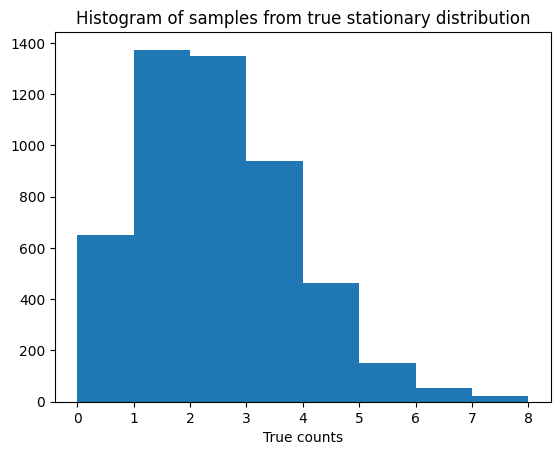

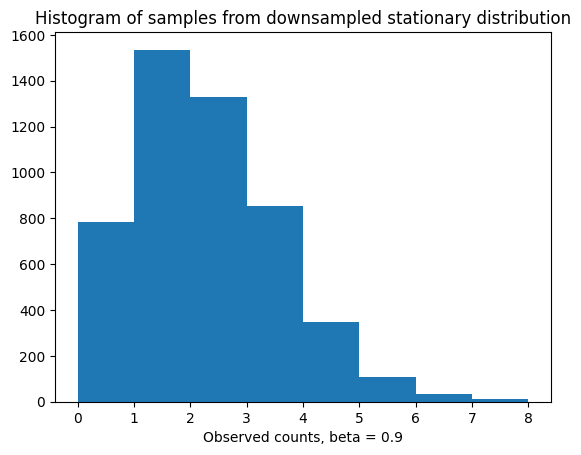

95% CI for m marginal p(0) is: (0.147, 0.167)
95% CI for m marginal p(1) is: (0.2938, 0.32)
95% CI for m marginal p(2) is: (0.253, 0.2774)
95% CI for m marginal p(3) is: (0.1602, 0.1812)
95% CI for m marginal p(4) is: (0.0624, 0.0762)
95% CI for m marginal p(5) is: (0.0174, 0.0254)
95% CI for m marginal p(6) is: (0.0048, 0.0094)
95% CI for m marginal p(7) is: (0.0008, 0.0034)
95% CI for m marginal p(8) is: (0.0, 0.001)


In [34]:
# parameters
params = [1, 0, 2, 1]
beta = 0.9

# simulate true and observed samples
samples = simulated_samples(params, 5000, beta, plot_true=True, plot_downsampled=True)

# CI for observed samples
intervals = bootstrap_approx(samples['sample_downsampled'], 5000, printing=True)

# mean of observed sample
sample_mean = mean_CI(samples['sample_downsampled'])

In [126]:
# choice of truncation
x_max = 8
x_max_0 = 200

In [127]:
# solve LP
variables = [0.9, 0.1, "v", 1]
solution = gene_expression_LP_upscaling(variables, intervals, beta, x_max, x_max_0, sample_mean, frechet_bounds=True, frechet_bounds_further=True)


k_on = 0.9

k_off = 0.1

k_tx in (1.8874800825249731, 3.5719935195517767) , status: optimal , optimal

k_deg = 1
